企業の製品発売やプレスリリースの反応をチェックするのに，ツイッターなどの文章から感情分析(sentiment classification)を行いたい．  
これは意見マイニング(opinion mining)とも呼ばれ，研究開発が勧められている．  
前章のクラス分類の知識も応用して，自前で感情分類器を作る．  

# まとめ
ツイートのポジティブ/ネガティブ分類器を作る．  
- ナイーブベイズ
    - 分類したいクラスを$C$,特徴量を$F_1, F_2$とするとベイズの定理から$$ P(C | F_1, F_2) = \frac{P(C) \cdot P(F_1, F_2 | C)}{P(F_1, F_2)} $$
    - $P(C | F_1, F_2)$: 事後確率 $F_1$と$F_2$がわかっているとき，そのデータがクラス$C$に属する確率
    - $P(C)$: 事前確率, データについて何も情報がない場合にそのデータがクラス$C$に属する確率
    - $P(F_1, F_2 | C)$: 尤度, あるデータがクラス$C$に属することがわかっている場合，特徴量がその$F_1，F_2$である確率
    - $P(F_1, F_2)$: 証拠, 特徴量がその$F_1$と$F_2$をとる確率, 該当する特徴量が全体に占める割合を計算して求める
    - これよりクラスの判定結果は$$ C_{best} = \arg \max_{c \in C} P(C=c) \cdot P(F_1 | C=c) \cdot P(F_2 | C=c) $$
    - 新出データに対して確率を求めると証拠が0になってしまうので，全ての単語が1度は出ていることを仮定するスムージングを行う．
        - 加算スムージング(ラプラススムージング): 全ての頻度に1を足す
        - Lidstoneスムージング: 0以上のパラメータ$\alpha$を足す
    - 実用上は，限りなく小さい確率の積によるアンダーフローを防ぐため，積を和に変換できる対数をとる．この場合，
    $$ C_{best} = \arg \max_{c \in C} \log P(C=c) + \sum_k \log P(F_k | C=c) $$
    - sklearnには3つのナイーブベイズ分類器が用意されている． 今回はMultinomialNBを利用．
        - GaussianNB: 特徴量が正規分布(ガウス分布)にしたがって分布すると仮定, 身長と体重から性別を分類する問題など
        - MultinomialNB: ある事象が発生した回数を特徴量としていると仮定, TF-IDFと相性がよい
        - BernoulliNB: 単語が出現した / 出現していない の2値で特徴量が表される場合に適している．  
<br>
- ポジティブとネガティブを判定する分類器
    - TfidfVectorizer->MultinomialNB というモデルを Pipelineで繋いだモデルで分類．
    - 以降，データが少ないので，交差検定を行う．ShuffleSplitでテストデータと訓練データを分ける．
    - 正解率80%, AUC(Area Under precision-recall curve)88%(以下80/88のように表記)の良い感じの結果に．  
<br>
- 全てのクラスを判定する分類器
    - 感情を含む / 含まない: 79/67: 感情を含むツイートは2割なので役立たず
    - ポジティブ/ その他: 90/27: PRカーブの成績が悪い
    - ネガティブ/ その他: 88/47: PRカーブの成績が悪い
    - データに偏りがあるのでPRカーブを信じるべき．するとこの結果はあまり良くない．  
<br>
- 感情を含む / 含まないの判定についてパラメータ最適化を行なった分類器
    - GridSearchCVによって交差検定(Cross Validation)の結果が最も良いパラメータを全探索
        - Param_grid = {"vect__ngram_range": [(1,1), (1,2), (1,3)]} のような辞書を作る．
    - 交差検定の指標にはF値(metrics.f1_scoreで実装)を用いる．$$ F = \frac{2 \cdot precision \cdot recall}{precision + recall} $$
        - precisionとrecallの調和平均(逆数の平均の逆数,率の平均を取るのに適する,値の小さい方に引っ張られる平均)
    - 感情を含む / 含まない: 83/70 ちょっと良くなった  
<br>
- ツイートの整形を行う分類器(パラメータ最適)
    - TfidfVectorizerにpreprocessorを渡す．
        - 顔文字を単語に変換
        - 短縮系の言葉を単語に分割
    - pos vs neg: 80/88, emo vs rest: 83/70, pos vs rest: 91/51, neg vs rest: 90/65  
<br>
- 単語のポジネガスコアを利用する分類器(パラメータ最適，整形済み)
    - nltk.pos_tag(nltk.word_tokenize("This is a sentense.")) による単語品詞タグづけ(Penn Treebankプロジェクト)
    - SentiWordNetのデータによる「品詞/単語」のポジネガスコアを獲得し，特徴量とする
    - BaseEstimatorを継承して，ポジネガスコアを特徴量として算出するクラスを作り，TfidfVectorizerの特徴量とFeatureUnionによって合わせる．
    - pos vs neg: 80/88, emo vs rest:83/69, pos vs rest: 91/52, neg vs rest: 89/62, 努力の割にはそんなに変わらず
    - まず感情があるかないかを分類してからポジネガ分類器にかけると良いかもしれない．

# 本章のロードマップ
Twitterは文字数が短いため，特別な表記法や略語などが用いられる．  
パラグラフごとに感情に関する情報を集めて，その結果から文書全体の感情分析を行いたいが，できない．  
ここでは最先端の感情分類器までは踏み込まず，以下の3つのことに取り組む
- ナイーブベイズという分類手法を学ぶ
- 品詞タグ付け(Part-of-Speech tagging)について学ぶ
- scikit-learnのツールの使い方を学ぶ

# ツイートデータを取得する
ツイートとそれに対応するラベル(意見なし,ポジティブ，ネガティブ，無感情)一式が欲しい．  
Niek Sandersらによって5000以上のツイートに対して手作業でラベル付けが行われたコーパスを使用する．  
install.pyによってTwitterのサーバとやりとりしてデータをダウンロードできる．

install.pyは使い物にならないので  
https://raw.githubusercontent.com/zfz/twitter_corpus/master/full-corpus.csv  
から直接full-corpus.csvをダウンロードし，dataフォルダに置く

In [1]:
import numpy as np
import csv, os

def load_sanders_data():
    with open(os.path.join("data", "full_corpus.csv"), "r", encoding='utf-8') as f:
        data = np.asarray([ [tweet, label] for _, label, _, _, tweet in csv.reader(f) ][1:])
    return data[:, 0], data[:, 1]

In [2]:
X, Y = load_sanders_data()
print(X[:5])
classes = np.unique(Y) # 全ラベルの種類を取得
for c in classes:
    print("#%s: %i" % (c, sum(Y == c)))

['Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is'
 '@Apple will be adding more carrier support to the iPhone 4S (just announced)'
 "Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY"
 '@RIM you made it too easy for me to switch to @Apple iPhone. See ya!'
 'I just realized that the reason I got into twitter was ios5 thanks @apple']
#irrelevant: 1689
#negative: 572
#neutral: 2333
#positive: 519


以降では，意見なし(irrelevant)と感情なし(neutral)を同じものとして扱う

# ナイーブベイズ分類器の紹介
ナイーブベイズはもっとも洗練された機械学習アルゴリズムの一つと言える．  
出力と関係ない特徴量にロバスト，つまり無関係な特徴量をうまく無視する．  
学習，予測は高速で，メモリを必要としない．  
ナイーブと呼ばれるのは，全ての特徴量が互いに独立である，という過程が必要であるから．  
実際にはその過程が成立するのは稀であるがたとえそれが成立しなくても優れた性能を示すことが多い．  

マークダウンの左寄せが効かないのでHTMLで無理やり

In [3]:
%%html
<style>td, th{text-align: left !important}</style>

## ベイズ定理入門
ナイーブベイズ分類器が行なっているのは，クラスを分類するためにどの特徴量が証拠となるかということを追跡すること．  
ここでは，次の変数を例として使用する．  

|変数|取りうる値|意味|
| :- | :- | :- |
|C|"pos", "neg"|ツイートが属するクラス(ポジティブ，ネガティブ)|
|F1|Int(>=0)|ツイートで「awesome」という単語が用いられた回数|
|F2|Int(>=0)|ツイートで「crazy」という単語が用いられた回数|

ナイーブベイズでは，あるツイートについて，F1とF2がわかっている時そのツイートがクラスCに属する確率を求めている．  
この確率関数は$P(C | F_1, F_2)$と書くことができる．  
この確率は直接推定できないので，ベイズの定理を用いて式を変形する．  
ベイズの定理を以下に示す．  
$$ P(A) \cdot P(B|A) = P(B) \cdot P(A|B) $$
この式を使うと，  
$$ P(F_1, F_2) \cdot P(C | F_1, F_2) = P(C) \cdot P(F_1, F_2 | C) $$
これを変形し，左辺に$ P(C | F_1, F_2) $ がくるようにすると
$$ P(C | F_1, F_2) = \frac{P(C) \cdot P(F_1, F_2 | C)}{P(F_1, F_2)} $$
これは，次のように言い換えられる．  
- posterior: 事後確率, $P(C | F_1, F_2)$, $F_1$と$F_2$がわかっているとき，そのデータがクラス$C$に属する確率
- prior: 事前確率, $P(C)$, データについて何も情報がない場合にそのデータがクラス$C$に属する確率
- likelihood: 尤度, $P(F_1, F_2 | C)$, あるデータがクラス$C$に属することがわかっている場合，特徴量がその$F_1，F_2$である確率
- evidence: 証拠, $P(F_1, F_2)$, 特徴量がその$F_1$と$F_2$をとる確率, 該当する特徴量が全体に占める割合を計算して求める

という言葉を使って，
$$ posterior = \frac{prior \cdot likelihood}{evidence} $$

likelihoodを求めるのは少し考える必要がある．  

## ナイーブにする
確率理論($P(A, B) = P(B) \cdot P(A | B) $)から次の式が成り立つ
$$ P(F_1, F_2 | C) = P(F_1 | C) \cdot P(F_2 | C, F_1)$$
この式は，難しい問題$P(F_1, F_2 | C)$を別の難しい問題$P(F_2 | C, F_1)$に変換したにすぎない．  
<br>
ここで，$F_1$と$F_2$が独立であると仮定(ナイーブ)すると，$P(F_2 | C, F_1)$を$P(F_2 | C)$とかけるため，次のように書き直すことができる．  
$$ P(F_1, F_2 | C) = P(F_1 | C) \cdot P(F_2 | C)$$
<br>
これを合わせると，次の有用な式を得られる．  
$$ P(C | F_1, F_2) = \frac{P(C) \cdot P(F_1 | C) \cdot P(F_2 | C)}{P(F_1, F_2)} $$
<br>
独立の過程は都合的なもので理論的には正しくないが，現実のアプリケーションでは優れた結果になることが多くあるのが興味深い．

## ナイーブベイズを用いて分類を行う
新しいツイートが与えられた時に行うことは，単純に次の確率を計算することである．  
$$ P(C = "pos" | F_1, F_2) = \frac{P(C="pos") \cdot P(F_1 | C="pos") \cdot P(F_2 | C="pos")}{P(F_1, F_2)} $$
$$ P(C = "neg" | F_1, F_2) = \frac{P(C="neg") \cdot P(F_1 | C="neg") \cdot P(F_2 | C="neg")}{P(F_1, F_2)} $$
これらのうち，確率の大きい方を選ぶため，同じ式である分母は無視できる．  
この計算では，実際の確率には興味がなく，どちらのクラスの方があり得るか，ということに興味がある．  
このことが，ナイーブベイズのロバスト性を高めている理由になっている．  
<br>
以上を一般化すると，次の式によってツイートを分類できる．  
$$ C_{best} = \arg \max_{c \in C} P(C=c) \cdot P(F_1 | C=c) \cdot P(F_2 | C=c) $$

実際の例を使って計算を行なってみる．  
次のようなラベル付きデータが与えられているとする．  

|ツイート|クラス|
|:--|:--|
|awesome|pos|
|awesome|pos|
|awesome crazy|pos|
|crazy|pos|
|crazy|neg|
|crazy|neg|

このデータから，事前確率は，  
$$ P(C=pos) = \frac{4}{6} \approx 0.67 $$
$$ P(C=neg) = \frac{2}{6} \approx 0.33 $$
これは，あるツイートについて，その内容を何も知らない場合は，それはポジティブであると予測した方が良いということ．  
<br>
次に，各条件付き確率を求めていく．  
例えば，クラスがposであるとわかっている時，awesomeが存在する確率は次のように表せる．  
$$ P(F_1 > 0 | C=pos) = \frac{3}{4} = 0.75 $$
同様にして，
$$ P(F_2 > 0 | C=pos) = 0.5 $$
$$ P(F_1 > 0 | C=neg) = 0 $$
$$ P(F_2 > 0 | C=neg) = 1 $$
<br>
ここでは，試しにevidenceも計算し，実際の確率を求めてみる．  
$$ P(F_1, F_2) = P(F_1, F_2 | C=pos) \cdot P(C=pos) + P(F_1, F_2 | C=neg) \cdot P(C=neg) $$
実際には次の値になる．  
$$ P(F_1 > 1, F_2 > 1) = 0.22 $$
$$ P(F_1 > 1, F_2 > 0) = 0.44 $$
$$ P(F_1 > 0, F_2 > 1) = 0.33 $$
$$ P(F_1 > 0, F_2 > 0) = 0 $$
<br>
あとは，新しいツイートから特徴量$F_1$，$F_2$を抽出し，分類器に入力するだけ．  
awesome -> P: 0.57, N: 0 -> Positive  
crazy -> P: 0.25, N: 1 -> Negative  
awesome crazy -> P: 0.76, N: 0 -> Positive  
text -> P: ∞, N: ∞ （分母となるevidenceが0) -> 不確定  
<br>
この不確定な時にはどのように対応すれば良いか？  

## 新出単語への対応
上の例は明らかにデータが足りない．不確定な値も出てしまう．  
そこで，出現頻度に1を足すスムージング，(加算スムージング, additive smoothing, ラプラススムージング(Laplace Smoothing))を利用する．  
ポリゴンメッシュを滑らかにする画像処理のラプラシアンスムージングとは関係ない．  
調整可能な0以上のパラメータ$\alpha$を足す，Lidstoneスムージングという手法も存在する．  
<br>
加算スムージングを行うことで，例えば
$$ P(F_1 > 0 | C=pos) = \frac{3}{4} = 0.75 $$
の代わりに，
$$ P(F_1 > 0 | C=pos) = \frac{3＋1}{4+2} = 0.67 $$
という計算になる．  
分母に2が足されるのはスムージング後も確率の定義を満たすためであり，$|C| = 2$であるため．  
これで不確定な値はなくなる．

## アンダーフローへの対応
特徴量が増えるごとに確率がどんどん小さくなっていく．  
すると，Pythonでは追えなくなる程の小ささになってしまう．  
これに対応するため，次の公式を利用する．  
$$ \log(x \cdot y) = log(x) + log(y) $$
$C_{best}$を求めるための公式の右辺の対数を取り，この公式を使うと  
$$ \log[ P(C) \cdot P(F_1 | C) \cdot P(F_2 | C) ] = \log P(C) + \log P(F_1 | C) + \log P(F_2 | C) $$
対数をとっても値の大小は変わらない(対数関数が単調増加)ので同様にクラスを選べる．  
以上を一般化することで，$C_{best}$を求める新しい式は次のようになる．  
$$ C_{best} = \arg \max_{c \in C} \log P(C=c) + \sum_k \log P(F_k | C=c) $$

## 最初の分類器を作成し，調整を行う
sklearn.naive_bayesパッケージには3つのナイーブベイズ分類器がある．  
- GaussianNB
    - 特徴量が正規分布(ガウス分布)にしたがって分布すると仮定
    - 身長と体重から性別を分類する問題など
- MultinomialNB
    - ある事象が発生した回数を特徴量としていると仮定
    - TF-IDFと相性がよい
- BernoulliNB
    - 単語が出現した / 出現していない の2値で特徴量が表される場合に適している．

我々はこれから，単語の出現回数を特徴量として用いるので，MultinomialNBを利用する．  

## 簡単な問題を最初に解く
ここでは問題を簡単にするため，irrelevant， neutralを除いたpositive, negativeのみのツイートを対象とする．  

In [37]:
X, Y = load_sanders_data()
pos_neg_idx = np.logical_or(Y=="positive", Y == "negative") # 集合に対する，論理和による選択
X = X[pos_neg_idx]
Y = Y[pos_neg_idx]
Y = Y == "positive" # positiveはTrue, negativeはFalseとなるラベル配列を作成

TfidfVectorizerを使って，生のテキストデータをTF-IDF(3章を参照, 全ての文書の中でその単語がどれだけレアか)特徴量に変換する．  
ここでは，ベクトル化を行う機能と分類器を合わせて持つことができるPipelineクラスを使用する．  
なぜ単語の重要性が特徴量になるのか？

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

def create_ngram_model():
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1, 3), analyzer="word", binary=False) # 1~3gramで全て特徴量を作り，まとめて一つの特徴空間にする
    clf = MultinomialNB()
    pipeline = Pipeline([ ('vect', tfidf_ngrams), ('clf', clf)]) # データを入れると，まずTF-IDFに変換してくれるようなパイプラインを作成
    return pipeline

# ここでパイプラインに名前がついているのは，パラメータ探索を自動で行うGridSearchで使える．

我々はデータをあまり持っていないので，テストデータと訓練データをとっかえひっかえする交差検定を使う．  
今回はKFoldではなく，テストデータをシャッフルして抽出するShuffleSplitを用いる．  
交差検定の各試行では，「適合率-再現率曲線より下の面積(AUC)」と正解率を求める．

In [39]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import ShuffleSplit
# ShuffleSplitについて https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

import matplotlib.pyplot as plt
%matplotlib inline

def pr_curve(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.fill_between(recalls, precisions, facecolor='blue', alpha=0.5)
    plt.grid()
    plt.xlabel("recall")
    plt.ylabel("precisions")
    plt.title("precision-recall curve (AUC = %.3f)" % auc(recalls, precisions))

def train_model(clf_factory, X, Y, prc=True):
    # 乱数の再現ができるようにrandom_stateを0にする
    rs = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    
    scores = []
    pr_scores = []
    
    for train, test in rs.split(X):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]
        
        clf = clf_factory()
        clf.fit(X_train, y_train) # 訓練データを与え，TF-IDF+MultinomialNBモデルにフィッティングする
        
        train_score = clf.score(X_train, y_train) # 訓練データに対する正解率を取得
        test_score = clf.score(X_test, y_test) # テストデータに対する正解率を取得
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test) # テストデータに対する予測結果を確率で
        
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, 1]) # ポジティブである確率を出す
        
        pr_scores.append(auc(recall, precision))
    
    summary = (np.mean(scores), np.std(scores), np.mean(pr_scores), np.std(pr_scores))
    print("Acc: %.3f \t AccStd: %.3f \t AUC: %.3f \t AUCStd: %.3f" % summary)
    
    if prc: pr_curve(precision, recall)

Acc: 0.800 	 AccStd: 0.021 	 AUC: 0.887 	 AUCStd: 0.025


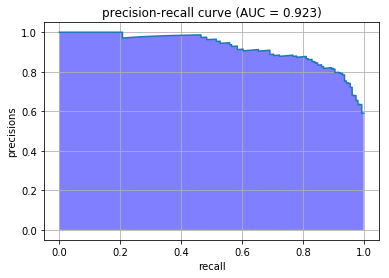

In [40]:
train_model(create_ngram_model, X, Y)

正解率80%, AUC 88.7%を達成  
人間でも感情分析を100%の精度で行うのは不可能であるので，この結果はとても良い結果と言える．

## 全てのクラスを対象とする
ツイートが感情を含むかどうかを分類するには？  
感情の含まれるツイートを陽性と解釈し直すよう配列を修正

In [8]:
def tweak_labels(Y, pos_sent_list):
    # Yはオリジナルのクラスラベル配列
    # pos_sent_listには["positive", "negative"]のような配列が入力される
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label # or演算，どちらかがTrueならTrueになる．ちなみに数値のビット演算にも使える．
    
    # 選ばれたラベルのところを1に，そうでないところを0にする
    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    Y = Y.astype(int) # numpy配列の要素をint型に変換
    
    return Y

ツイートに感情があるかないかを判別する．

Acc: 0.793 	 AccStd: 0.008 	 AUC: 0.675 	 AUCStd: 0.022


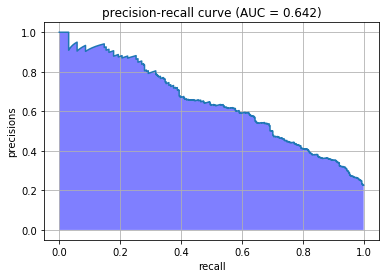

In [9]:
X, Y = load_sanders_data()
Y = tweak_labels(Y, ["positive", "negative"])
train_model(create_ngram_model, X, Y)

ここで，感情を含むツイートは全体の20%程度である偏ったものであることに留意すると，ツイートを見なくても感情を含むかどうかは8割でわかる．  
ということは，この正答率0.793はツイートを見ていないのと同程度の正解率であり，役に立たない．  

つぎに，ナイーブベイズ分類器がポジティブとそれ以外を分類する場合を調べてみる．

Acc: 0.901 	 AccStd: 0.004 	 AUC: 0.279 	 AUCStd: 0.036


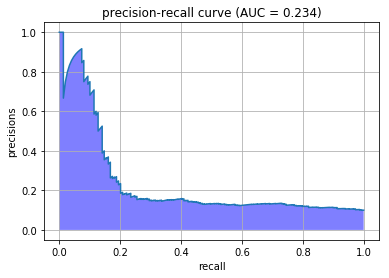

In [10]:
# ポジティブ vs その他
X, Y = load_sanders_data()
Y = tweak_labels(Y, ["positive"])
train_model(create_ngram_model, X, Y)

Acc: 0.887 	 AccStd: 0.007 	 AUC: 0.477 	 AUCStd: 0.030


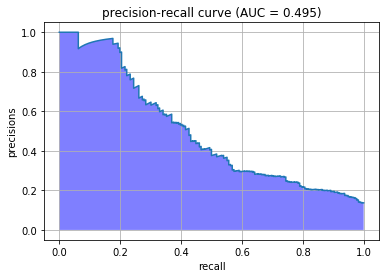

In [11]:
# ネガティブ vs その他
X, Y = load_sanders_data()
Y = tweak_labels(Y, ["negative"])
train_model(create_ngram_model, X, Y)

どちらもAUCが上がらない．

## 分類器のパラメータを調整する
TfidfVectorizerとMultinomialNBに適当なパラメータを割り当ててみる  
- TfidfVectorizer
    - NGramsについて，ユニグラム，バイグラム，トライグラムをそれぞれ試してみる
    - min_dfについては1,2の場合を試す
    - IF-IDFにおけるIDFの影響を検証するため，use_idfとsmooth_idfについてFalseとTrueの場合を試す
    - stop_wordsにEnglish，Noneを試す
    - 単語の頻度(sublinear_tf)について，対数を用いるかどうかを検証
    - 記録する対象を単語の出現回数か単語の出現の有無にするかをbinaryをTrueまたはFalseにして試す
- MultinomialNB
    - スムージングについて検証するため，alphaに次の値を設定
        - 1: ラプラススムージング
        - 0.01, 0.05, 0.1, 0.5: Lidstoneスムージング
        - 0: スムージングなし

これらの組み合わせを全てやっていると時間がかかる．  
こういったパラメータ探索には，sklearnのGridSearchCVと呼ばれるクラスを使うと良い．  
推定器(分類器のようなもの)インスタンスと候補となるパラメータ値を辞書で渡す．  
推定器としては，この場合Pipelineのインスタンスを入力する．  
パラメータ辞書は，キーを以下のフォーマットに従わせる必要がある．  
<br>
<div style="text-align: center">[estimator]__[subestimator]__...__[param_name]</div>
<br>
例えば，TfidfVectorizer(変数名vect)のngram_rangeパラメータについて候補となる値を探索する時には，  

In [12]:
Param_grid = {"vect__ngram_range": [(1,1), (1,2), (1,3)]}

となる.  
最終的な結果は，メンバ変数であるbest_estimator_に最適なパラメータの組み合わせが収められる．  
<br>
GridSearchCVのメンバ変数であるcv(Cross-Validation)にShuffleSplitインスタンスを渡すことで交差検定ができる．  
また，score_funcメンバ変数にスコアを算出する関数を指定する．  
我々が扱うデータには偏りがあるため，metric.accuracyを基準にするべきではない．  
<br>
ここでは，適合率と再現率から計算できる，F値(F-measure)を用いる．  
F値はmetrics.f1_scoreで実装されており，式は以下になる．  
$$ F = \frac{2 \cdot precision \cdot recall}{precision + recall} $$
<br>
F値はprecisionとrecallの[調和平均](https://mathtrain.jp/hmean)と呼ばれるもの.
調和平均$H$とは，平均を撮るものが$a, b$の2個の場合は，  
$$ \frac{1}{H} = \frac{1}{2} \Bigl( \frac{1}{a} + \frac{1}{b} \Bigr) $$
で表される．  
例えば，速度の問題で，「1kmの道を行きは$a$km/h, 帰りは$b$km/hで走った時の平均時速」は$H$になる．  
調和平均は，％，つまり率の平均を取るのに良いとされている．  

In [13]:
def harmonic_average(lst):
    return len(lst) / sum([1.0 / i for i in lst])

In [14]:
print("調和平均")
print(harmonic_average([0.5, 0.5]))
print(harmonic_average([0.1, 0.9]))
print(harmonic_average([0.1, 0.1]))
print(harmonic_average([0.9, 0.9]))
print()

print("相乗平均")
import math
print(math.sqrt(np.multiply.accumulate([0.5, 0.5])[-1]))
print(math.sqrt(np.multiply.accumulate([0.1, 0.9])[-1]))
print(math.sqrt(np.multiply.accumulate([0.1, 0.1])[-1]))
print(math.sqrt(np.multiply.accumulate([0.9, 0.9])[-1]))
print()

print("相加平均")
print(sum([0.5, 0.5]) / 2)
print(sum([0.1, 0.9]) / 2)
print(sum([0.1, 0.1]) / 2)
print(sum([0.9, 0.9]) / 2)

調和平均
0.5
0.18
0.1
0.8999999999999999

相乗平均
0.5
0.30000000000000004
0.1
0.9

相加平均
0.5
0.5
0.1
0.9


上記の結果からわかるように，調和平均は同じ値の時はそのままという平均の性質を保ちつつ，値が低い方に引っ張られやすいという性質を持つ．  
今回の場合，precisionもrecallも高い水準であって欲しいため，どちらかでも値が低いことに対してペナルティが大きい評価基準であると言える．

以上をまとめ，パラメータ調整を行なっていく．

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

def grid_search_model(clf_factory, X, Y):
    rs = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    
    param_grid = dict(
        vect__ngram_range=[(1, 1), (1, 2), (1, 3)],
        vect__min_df=[1, 2],
        vect__stop_words=[None, "english"],
        vect__smooth_idf=[False, True],
        vect__use_idf=[False, True],
        vect__sublinear_tf=[False, True],
        vect__binary=[False, True],
        clf__alpha=[0, 0.01, 0.05, 0.1, 0.5, 1],
    )
    
    # Pipelineで名付けたvect, clfに対して，param_gridで指定したパラメータを使ってグリッドサーチする．
    grid_search = GridSearchCV(
        clf_factory(), 
        param_grid=param_grid,
        cv = rs,
        scoring=make_scorer(f1_score),
        verbose=10
    )
    
    grid_search.fit(X, Y)
    
    return grid_search.best_estimator_

In [33]:
import pickle

try:
    with open("./data/06_clf_1.pkl", "rb") as f:
        clf = pickle.load(f)
        print("Optimized Classifier Parameters are Loaded through Pickle")
        print(clf)
except:
    X, Y = load_sanders_data()
    Y = tweak_labels(Y, ["positive", "negative"])

    # 1152通りのパラメータの組み合わせを交差検定するため，46分程度を要する
    clf = grid_search_model(create_ngram_model, X, Y)
    with open("./data/06_clf_1.pkl", "wb") as f:
        pickle.dump(clf, f)
    print(clf)

Optimized Classifier Parameters are Loaded through Pickle
Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=False,...se,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))])


In [34]:
clf.steps

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=1,
          ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=False,
          stop_words=None, strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=False,
          vocabulary=None)),
 ('clf', MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))]

Acc: 0.839 	 AccStd: 0.008 	 AUC: 0.702 	 AUCStd: 0.017


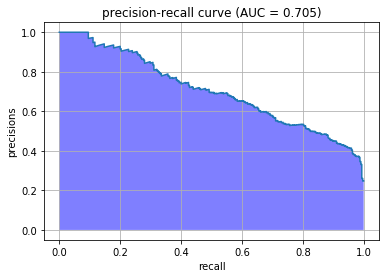

In [41]:
def optimized_ngram_model():
    return clf

X, Y = load_sanders_data()
X, Y = load_sanders_data()
Y = tweak_labels(Y, ["positive", "negative"])
train_model(optimized_ngram_model, X, Y)

AUCは3.3%程度向上する．Pos vs Rest, Neg vs Restに関しては10~20%程度のAUCの向上が見られる．  
しかし，大した向上ではない．  
続いて，データの整形を行うことで精度を上げていく．

# ツイートを整形する
TfidfVectorizerのpreprocessor()という自前の関数でツイートの整形，前処理を行う．  
手始めに顔文字を単語に書き換える．  


In [19]:
import re

emo_repl = {
    # ポジティブな顔文字
    "&lt;3": " good ",
    ":d": " good ",
    ":dd": " good ",
    "8)": " good ",
    ":-)": " good ",
    ":)": " good ",
    ";)": " good ",
    "(-:": " good ",
    "(:": " good ",
    
    # ネガティブな顔文字
    ":/": "bad",
    ":&gt": "sad",
    ":')'": "sad",
    ":-(": "bad",
    ":(": "bad",
    ":S": "bad",
    ":-S": "bad",
}

# たとえば，":dd"より先に":d"で置き換えられないように，置き換えの順番を決める
emo_repl_order = [k for (k_len, k) in sorted([(len(k), k) for k in emo_repl.keys()])[::-1] ]

# 略語を正規表現で対応づけ
# \b: 空文字列とマッチしますが、単語の先頭か末尾の時だけです。
# r'\bfoo\b' は'foo' , 'foo.' , '(foo)', 'bar foo baz' にマッチしますが、'foobar', 'foo3' にはマッチしません。
re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_ngram_model(params=None):
    
    def preprocessor(tweet):
        global emotions_replaced
        tweet = tweet.lower()
        
        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)
        
        return tweet
    
    tfidf_ngrams = TfidfVectorizer(
        preprocessor=preprocessor,
        ngram_range=(1, 2), 
        smooth_idf=False, 
        use_idf=False,
        binary=False)
    clf = MultinomialNB(alpha=0.01)
    pipeline = Pipeline([ ('vect', tfidf_ngrams), ('clf', clf)])
    return pipeline

In [20]:
X_org, Y_org = load_sanders_data()
print("pos vs neg")
pos_neg_idx = np.logical_or(Y_org=="positive", Y_org == "negative") # 集合に対する，論理和による選択
X = X_org[pos_neg_idx]
Y = Y_org[pos_neg_idx]
Y = Y == "positive"
train_model(create_ngram_model, X, Y, prc=False)

print("emo vs rest")
X = X_org
Y = tweak_labels(Y_org, ["positive", "negative"])
train_model(create_ngram_model, X, Y, prc=False)

print("pos vs rest")
X = X_org
Y = tweak_labels(Y_org, ["positive"])
train_model(create_ngram_model, X, Y, prc=False)

print("neg vs rest")
X = X_org
Y = tweak_labels(Y_org, ["negative"])
train_model(create_ngram_model, X, Y, prc=False)

pos vs neg
Acc: 0.804 	 AccStd: 0.014 	 AUC: 0.889 	 AUCStd: 0.020
emo vs rest
Acc: 0.838 	 AccStd: 0.008 	 AUC: 0.704 	 AUCStd: 0.017
pos vs rest
Acc: 0.912 	 AccStd: 0.005 	 AUC: 0.511 	 AUCStd: 0.043
neg vs rest
Acc: 0.908 	 AccStd: 0.008 	 AUC: 0.653 	 AUCStd: 0.024


顔文字は限定されたものであるが，結構精度を向上させることができた．

# 単語の種類を考慮する
名詞よりも形容詞や動詞の方が感情を含むツイートに多く含まれていそう．  
品詞タグづけ(part of speech (POS) tagging)  
POSタガー： 文章全体をパースし，単語の依存関係を分析することで，bookのような名詞にも動詞にもなれたりする単語に品詞タグづけを行う  
今回はnltkに入っている品詞タガーを使う．  

In [21]:
import nltk

In [22]:
# データのダウンロード，詳しくはゼロから作るディープラーニング2の付録のノートブックを参照
nltk.download(download_dir="./data", info_or_id="punkt")
nltk.download(download_dir="./data", info_or_id="averaged_perceptron_tagger")
nltk.data.path.append('/Users/komatsu/programing/machinelearning/BuildingMachineLearningSystems/data')

[nltk_data] Downloading package punkt to ./data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     ./data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [23]:
token = nltk.word_tokenize("This is a book.")
print(token)

print(nltk.pos_tag(token))

print(nltk.pos_tag(nltk.word_tokenize("Could you please book the flight?")))

['This', 'is', 'a', 'book', '.']
[('This', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('book', 'NN'), ('.', '.')]
[('Could', 'NNP'), ('you', 'PRP'), ('please', 'VBP'), ('book', 'NN'), ('the', 'DT'), ('flight', 'NN'), ('?', '.')]


DTとかVBZとかは品詞を表す．  
その意味は以下(http://www.anc.org/OANC/penn.html より転載)  

<TABLE border="2" cellspacing="2">
<TR><TH> POS Tag  </TH><TH> Description     </TH><TH> Example </TH></TR>
<TR><TD> CC  </TD><TD> coordinating conjunction  </TD><TD> and </TD></TR>
<TR><TD> CD  </TD><TD> cardinal number </TD><TD> 1, third </TD></TR>
<TR><TD> DT  </TD><TD> determiner  </TD><TD> the  </TD></TR>
<TR><TD> EX  </TD><TD> existential there </TD><TD> <i>there</i> is </TD></TR>
<TR><TD> FW  </TD><TD> foreign word  </TD><TD> d'hoevre  </TD></TR>
<TR><TD> IN  </TD><TD> preposition/subordinating conjunction </TD><TD> in, of, like </TD></TR>
<TR><TD> JJ   </TD><TD> adjective    </TD><TD> green  </TD></TR>
<TR><TD> JJR   </TD><TD> adjective, comparative    </TD><TD> greener  </TD></TR>
<TR><TD> JJS   </TD><TD> adjective, superlative    </TD><TD> greenest  </TD></TR>
<TR><TD> LS  </TD><TD> list marker  </TD><TD> 1)  </TD></TR>
<TR><TD> MD  </TD><TD> modal </TD><TD> could, will </TD></TR>
<TR><TD> NN  </TD><TD> noun, singular or mass </TD><TD> table </TD></TR>
<TR><TD> NNS </TD><TD>  noun plural </TD><TD> tables </TD></TR>
<TR><TD> NNP </TD><TD>  proper noun, singular  </TD><TD> John      </TD></TR>
<TR><TD> NNPS </TD><TD> proper noun, plural  </TD><TD> Vikings  </TD></TR>
<TR><TD> PDT  </TD><TD> predeterminer  </TD><TD> <i>both</i> the boys  </TD></TR>
<TR><TD> POS  </TD><TD> possessive ending  </TD><TD> friend<i>'s</i>  </TD></TR>
<TR><TD> PRP  </TD><TD> personal pronoun  </TD><TD> I, he, it </TD></TR>
<TR><TD> PRP(doller)  </TD><TD> possessive pronoun  </TD><TD> my, his </TD></TR>
<TR><TD> RB   </TD><TD> adverb   </TD><TD> however, usually, naturally, here, good </TD></TR>
<TR><TD> RBR   </TD><TD> adverb, comparative   </TD><TD> better</TD></TR>
<TR><TD> RBS   </TD><TD> adverb, superlative   </TD><TD> best </TD></TR>
<TR><TD> RP   </TD><TD> particle  </TD><TD> give <i> up </i></TD> </TR>
<TR><TD> TO  </TD><TD> to </TD><TD> <i>to</i> go, <i>to</i> him </TD> </TR>
<TR><TD> UH  </TD><TD> interjection  </TD><TD> uhhuhhuhh </TD> </TR>
<TR><TD> VB  </TD><TD> verb, base form  </TD><TD> take  </TD></TR>
<TR><TD> VBD </TD><TD>  verb, past tense   </TD><TD> took </TD></TR>
<TR><TD> VBG </TD><TD>  verb, gerund/present participle </TD><TD> taking  </TD></TR>
<TR><TD> VBN  </TD><TD> verb, past participle    </TD><TD> taken     </TD></TR>
<TR><TD> VBP  </TD><TD> verb, sing. present, non-3d  </TD><TD>  take </TD> </TR>
<TR><TD> VBZ  </TD><TD> verb, 3rd person sing. present  </TD><TD> takes   </TD></TR>
<TR><TD> WDT   </TD><TD> wh-determiner    </TD><TD> which  </TD></TR>
<TR><TD> WP   </TD><TD> wh-pronoun  </TD><TD> who, what </TD></TR>
<TR><TD> WP(doller)   </TD><TD> possessive wh-pronoun  </TD><TD> whose  </TD></TR>
<TR><TD> WRB   </TD><TD> wh-abverb  </TD><TD> where, when </TD></TR>
</TABLE>

ここでは単純に，NN->名詞， VB->動詞， JJ->形容詞, RB->副詞としてカウント

##  SentiWordNetを活用する
さらに，多くの英単語にポジティブ，ネガティブの度合いをスコアとしてデータ化した，[SentiWordNet](https://sentiwordnet.isti.cnr.it/)を利用する．  
それぞれの単語について，POS, ID, PosScore, NegScore, SynsetTerms, Descriptionがある．  
例えばfantasizeという単語には，想像する，という意味と~を思い浮かべて欲情する，という意味があり，この場合は別々の意味についてスコア化されている．  
ここでは簡単のため，複数の同義語はPosスコアとNegスコアでそれぞれ平均をとる．   
キーとしてn/implantのような単語，バリューとしてポジティブスコアとネガティブスコアを持つ辞書を返す関数load_sent_word_netを作成

In [24]:
import csv, collections
def load_sent_word_net():
    sent_scores = collections.defaultdict(list)
    
    with open("./data/SentiWordNet.txt", "r") as f:
        reader = csv.reader(f, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#") or len(line) == 1 : # コメントは飛ばす
                continue
            
            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0:
                continue
            
            for term in SynsetTerms.split(" "):
                # 最後の要素は取り除く
                term = term.split("#")[0]
                term = term.replace("-", " ").replace("_", " ")
                key = "%s/%s" %(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))
    
    for key, value in sent_scores.items():
        sent_scores[key] = np.mean(value, axis=0)
    
    return sent_scores

## 最初の推定器
上記で説明したようにして，新たな特徴量を抽出するため，BaseEstimatorを継承したクラスを実装する．  
以下のメソッドを実装する必要がある．
- get_feature_names(): 特徴量の名前のリストを返す．  
- fit(document, y=None): このクラスでは分類器まで実装しないため無視できるが，selfを返す．  
- transform(documents): get_feature_namesで指定した特徴量の計算を行う．  (len(documents), len(get_feature_names))の大きさのnp配列を返す．

In [25]:
from sklearn.base import BaseEstimator

sent_word_net = load_sent_word_net()

class LinguisticVectorizer(BaseEstimator):
    
    # ここで定義した特徴量をtransformで計算して返す
    def get_feature_names(self):
        return np.array(
            ['sent_neut', 'sent_pos', 'sent_neg', 'nouns', 'adjectives', 'adverbs', 'allcaps', 'exclamation', 'question', 'hashtag', 'mentioning']
        )
    
    # ここではfit関数は必要ないが，selfを返すことで，fit(d).transform(d)のような使い方ができる．
    def fit(self, documents, y=None):
        return self
    
    # nltkの品詞(Part of Speech, POS)タグと，それを元にしたsent_word_netのpos negスコアなどを返す
    def _get_sentiments(self, d):
        sent = tuple(d.split())
        tagged = nltk.pos_tag(sent) # それぞれの単語についてタグを取得
        
        pos_vals = []
        neg_vals = []
        
        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.
        
        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            
            if t.startswith("NN"):
                sent_pos_type="n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1
            
            # 品詞がわかったらsent_word_netにその単語があるかを検索し，pos neg スコアを辞書から獲得
            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)
                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]
            
            pos_vals.append(p)
            neg_vals.append(n)
        
        l = len(sent)
        avg_pos_val = np.mean(pos_vals) # 文書の平均ポジティブスコア
        avg_neg_val = np.mean(neg_vals) # 文書の平均ネガティブスコア
        return [1 - avg_pos_val - avg_neg_val, avg_pos_val, avg_neg_val, nouns/l, adjectives/l, verbs/l, adverbs/l]
    
    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array([self._get_sentiments(d) for d in documents]).T
        
        allcaps = []
        exclamation = []
        question = []
        hashtag = []
        mentioning = []
        
        for d in documents:
            allcaps.append(np.sum([t.isupper() for t in d.split() if len(t) > 2]))  # 全て大文字の単語の数を感情分析に利用, t: 単語, d: ドキュメント
            exclamation.append(d.count("!"))
            question.append(d.count("?"))
            hashtag.append(d.count("#"))
            mentioning.append(d.count("@"))
        
        return np.array([obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps, exclamation, question, hashtag, mentioning]).T

## 全てを統合する
上記の言語学に関する情報に加え，TfidfVectorizerを合わせて利用する．  
これには，sklearnのFeatureUnionクラスを利用する．  
FeatureUnionは推定器の評価に，順に特徴量の抽出を行うのではなく，並列に計算を行い，最後に結果となるベクトルをまとめる．

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion

def create_union_model(params=None):
    def preprocessor(tweet):
        tweet = tweet.lower()
        for k in emo_repl_order:
            tweet = tweet.replace(k, emo_repl[k])
        for r, repl in re_repl.items():
            tweet = re.sub(r, repl, tweet)
        
        return tweet.replace("-", " ").replace("_", " ")
    
    tfidf_ngrams = tfidf_ngrams = TfidfVectorizer(
        preprocessor=preprocessor,
        ngram_range=(1, 2), 
        smooth_idf=False, 
        use_idf=False,
        binary=False)
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion([('ling', ling_stats), ('tfidf', tfidf_ngrams)])
    clf = MultinomialNB(alpha=0.01)
    pipeline = Pipeline([('all', all_features), ('clf', clf)])
    
    if params:
        pipeline.set_params(**params)
    
    return pipeline

In [31]:
X_org, Y_org = load_sanders_data()
print("pos vs neg")
pos_neg_idx = np.logical_or(Y_org=="positive", Y_org == "negative") # 集合に対する，論理和による選択
X = X_org[pos_neg_idx]
Y = Y_org[pos_neg_idx]
Y = Y == "positive"
train_model(create_union_model, X, Y, prc=False)

print("emo vs rest")
X = X_org
Y = tweak_labels(Y_org, ["positive", "negative"])
train_model(create_union_model, X, Y, prc=False)

print("pos vs rest")
X = X_org
Y = tweak_labels(Y_org, ["positive"])
train_model(create_union_model, X, Y, prc=False)

print("neg vs rest")
X = X_org
Y = tweak_labels(Y_org, ["negative"])
train_model(create_union_model, X, Y, prc=False)

pos vs neg
Acc: 0.803 	 AccStd: 0.020 	 AUC: 0.883 	 AUCStd: 0.018
emo vs rest
Acc: 0.834 	 AccStd: 0.008 	 AUC: 0.699 	 AUCStd: 0.012
pos vs rest
Acc: 0.913 	 AccStd: 0.005 	 AUC: 0.525 	 AUCStd: 0.040
neg vs rest
Acc: 0.897 	 AccStd: 0.006 	 AUC: 0.625 	 AUCStd: 0.020


結果としては低いわけではないが，性能は努力のわりにそんなに変わらない．  
ポジティブとそれ以外，ネガティブとそれ以外の分類器はそんなに使えなさそう．  
その代わりに，まずツイートに感情が含まれるかどうかを判定し，そのあとでpos vs negを通すのが良さそう．  

# まとめ
ナイーブベイズの仕組みについて学び，その性能を見た．  
ツイートされた文章にナイーブベイズを適用する方法を学び，ツイートの簡単な整形も行なった．  
最後に，NLTKの品詞タグづけ機能を使うことでSentiWordNetのデータから単語のポジネガスコアを獲得し，それを分類に利用する方法も学んだ．